In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

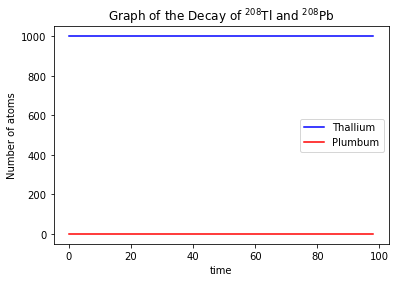

In [62]:
tau_Tl   = 3.052*60 
tau_Pb   = 3.052*60
N0           = 1000
t1           = 100
n_timepoints = 50

def simulate_monte_carlo1(N0, t1, n_timepoints):
    '''Monte carlo simulation'''
    dt             = 1  
    count_Tl   = np.zeros((n_timepoints)) 
    count_Pb = np.zeros((n_timepoints))
    atoms          = np.ones((N0)) 
    p_decay_Tl    = 1 - 2 * np.exp(-dt / tau_Tl) 
    p_decay_Pb    = 1 - 2 * np.exp(-dt / tau_Pb)
    
    for idx_time in range(n_timepoints):
        
        count_Tl[idx_time]   = (atoms == 1).sum() 
        count_Pb[idx_time] = (atoms == 2).sum()
        
        for idx_atom in range(N0):
            
            if atoms[idx_atom] == 1: 
                if np.random.random() <= p_decay_Tl:
                    atoms[idx_atom] = 2
                else:
                    atoms[idx_atom] = 1
            elif atoms[idx_atom] == 2:
                if np.random.random() <= p_decay_Pb:
                    atoms[idx_atom] = 3
                else:
                    atoms[idx_atom] = 2
                
    return count_Tl, count_Pb

timebase = np.arange(0, t1, t1/n_timepoints) 
n_Tl, n_Pb = simulate_monte_carlo1(N0, t1, n_timepoints)    

plt.figure() 
plt.plot(timebase, n_Tl, label = 'Thallium', color = 'blue')
plt.plot(timebase, n_Pb, label = 'Plumbum', color = 'red')
plt.title('Graph of the Decay of $^{208}$Tl and $^{208}$Pb')
plt.ylabel('Number of atoms')
plt.xlabel('time')
plt.legend(loc='right') 
plt.show()

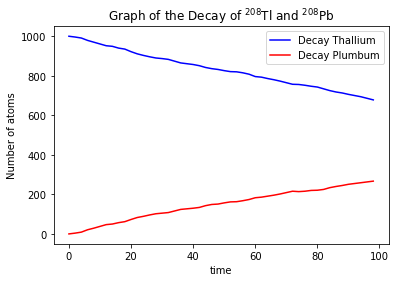

In [66]:
def simulate_monte_carlo2(N0, t1, n_timepoints):
    dt             = 1 #t1 / n_timepoints 
    count_Tl   = np.zeros((n_timepoints)) 
    count_Pb = np.zeros((n_timepoints))
    noncount_Tl   = np.zeros((n_timepoints)) 
    noncount_Pb = np.zeros((n_timepoints))
    atoms          = np.ones((N0)) 
    p_decay_Tl    = 2 * np.exp(-dt / t_half_Tl) * (np.log(2) / t_half_Tl) 
    p_decay_Pb    = 2 * np.exp(-dt / t_half_Pb) * (np.log(2) / t_half_Pb)
    for idx_time in range(n_timepoints):
        
        count_Tl[idx_time]   = (atoms == 1).sum() 
        count_Pb[idx_time] = (atoms == 2).sum()
        
        for idx_atom in range(N0):
            
            if atoms[idx_atom] == 1: 
                if np.random.random() <= p_decay_Tl:
                    atoms[idx_atom] = 2
                else:
                    atoms[idx_atom] = 1
            elif atoms[idx_atom] == 2:
                if np.random.random() <= p_decay_Pb:
                    atoms[idx_atom] = 3
                else:
                    atoms[idx_atom] = 2
                
    return count_Tl, count_Pb

timebase = np.arange(0, t1, t1/n_timepoints) 
n_Tl, n_Pb = simulate_monte_carlo2(N0, t1, n_timepoints)    

plt.figure() 
plt.plot(timebase, n_Tl, label = 'Decay Thallium', color = 'blue')
plt.plot(timebase, n_Pb, label = 'Decay Plumbum', color = 'red')
plt.title('Graph of the Decay of $^{208}$Tl and $^{208}$Pb')
plt.ylabel('Number of atoms')
plt.xlabel('time')
plt.legend(loc='upper right') 
plt.show()


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [81]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
#plt.plot(x,f(x),'r-')

# Monte Carlo integration
N=1000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I1=2*count/N
print("Hit and Miss method:", I1)


Ν = 1000
a = 0.001
b = 1.999
x = np.random.uniform(a,b,Ν)

f_x = (np.sin(1/(x*(2-x))))**2
I2 = np.mean(f_x)*(b-a)
print("Mean Value Method:", I2)

print("Relative Error:", np.abs((I1-I2) / I2))

Hit/ Miss method: 1.476
Mean Value Method: 1.4689745101706981
Relative Error: 0.004782581168467972


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [45]:
'''
def in_circle(x, y, Cx, Cy, R):
    return (x - Cx)**2 + (y - Cy)**2 <= R**2

def approximateCircleArea(R, N):
    squareSide = R*2
    Cx = R
    Cy = R
    
    c = 0
    for i in range(N):
        x = np.random.random()*squareSide
        y = np.random.random()*squareSide
        if in_circle(x,y, Cx, Cy, R):
            c = c + 1
    return c / N * squareSide**2

N = 10**3 # number of trials (ie, number of points to sample)
R = 1 # circle radius
approximateCircleArea(R,N)
'''
dim = 2
N = 10**6
y = np.random.uniform(low=-0, high=1,size=(N,dim))
p = np.sum(np.sqrt(y[:,0]**2 + y[:,1]**2) < 1)/N
print("Area of circle of unit radius is",4*p)

Area of circle of unit radius is 3.142328


In [47]:
dim = 10
N = 10**6

def nSphereVolume(dim, N):
    c = 0
    for i in range(N):
        p = np.random.uniform(-1, 1, dim)
        dist = np.linalg.norm(p)
        if dist < 1:
            c += 1
    return np.power(2.0, dim) * (c / N)

print("Generalized result of 10D sphere is",nSphereVolume(dim, N))

Generalized result of 10D sphere is 2.644992


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [57]:
from math import e
from sympy import symbols, integrate
x = symbols('x')
sol = integrate(x**(-1/2) / (e**(x) + 1), (x, 0,1)).evalf(16)
sol

0.8389329600133814